## Anomaly detection with Keras, TensorFlow

Autoencoder reconstruct images. But of course there will be difference from input images. This difference will be MSE(loss) for our model. The lower the loss, the better a job the autoencoder is doing at reconstructing the image. According to this, we will create a dataset with number '1's and some '3's as anomaly... But we don't tell the model which one is 1 and 3. It will automaticly figure it out as an anomaly detector 

If you train your models with 1's , reconstraction of 3 will cause a big MSE... And this is the basic idea of this notebook

We will use the same autoencoder that we created before. 

In [1]:

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import pickle
import cv2

In [2]:
# load the MNIST dataset
print("[INFO] loading MNIST dataset...")
((trainX, trainY), (testX, testY)) = mnist.load_data()

[INFO] loading MNIST dataset...


In [3]:
validLabel=1
anomalyLabel=3
contam=0.01
seed=42

In [4]:
unique, counts = np.unique(trainY, return_counts=True)

In [7]:
dict(zip(unique, counts))

{0: 5923,
 1: 6742,
 2: 5958,
 3: 6131,
 4: 5842,
 5: 5421,
 6: 5918,
 7: 6265,
 8: 5851,
 9: 5949}

We have 6742 '1' in TrainX dataset.

In [8]:
#validlabel is 1
validIdxs = np.where(trainY == validLabel)[0]


In [9]:
validIdxs

array([    3,     6,     8, ..., 59979, 59984, 59994], dtype=int64)

In [10]:
len(validIdxs)

6742

In [12]:
#for 3 indexs
anomalyIdxs = np.where(trainY == anomalyLabel)[0]

In [14]:
anomalyIdxs

array([    7,    10,    12, ..., 59978, 59980, 59996], dtype=int64)

In [13]:
len(anomalyIdxs)

6131

In [15]:
# randomly shuffle both sets of indexes
random.shuffle(validIdxs)
random.shuffle(anomalyIdxs)

In [16]:
validIdxs

array([46842, 29214, 50731, ...,  2767, 57957, 43984], dtype=int64)

validIdxs and anomalyIdxs were shuffled...

We will create dataset with %99 of 1 and %1 of3... We should find how many 3 we need

In [17]:
# compute the total number of anomaly data points to select
i = int(len(validIdxs) * contam)
print(i)

67


In [18]:
anomalyIdxs = anomalyIdxs[:i]

In [19]:
anomalyIdxs

array([38066, 11155, 11978, 48258, 35765, 17632, 59375, 56515,  2233,
       23287, 18742, 40619, 11755, 24350, 31451, 36409, 40375,  2076,
       35890, 39127, 58064, 38927,  4022, 26503, 32933, 54249,  1409,
       18363, 14761,  6497, 58249, 55432, 47519, 38245, 58678,  1244,
       12024,  2228, 44684, 27861, 35929, 21717, 28418, 27835, 52111,
       38086, 57199, 47602, 29816,  8946,   874, 46681,  4156, 12667,
       45554, 14552, 44146, 28431, 22024, 35491, 28825, 14863, 14635,
       40202, 22460,  6719,   433], dtype=int64)

In [20]:
len(anomalyIdxs)

67

In [21]:
#take the all 1's and 67 of 3's
validImages = trainX[validIdxs]
anomalyImages = trainX[anomalyIdxs]

In [22]:
validImages.shape

(6742, 28, 28)

In [23]:
anomalyImages.shape

(67, 28, 28)

In [24]:
# single data matrix and then shuffle the rows
images = np.vstack([validImages, anomalyImages])
np.random.seed(seed)
np.random.shuffle(images)

In [25]:
images.shape

(6809, 28, 28)

We have 6809 images with 6742 1's and 67 3's , but we don't know which one is which... 

In [26]:
# add a channel dimension to every image in the dataset for depth
# then scalethe pixel intensities to the range [0, 1]
images = np.expand_dims(images, axis=-1)
images = images.astype("float32") / 255.0

In [27]:
images.shape

(6809, 28, 28, 1)

In [28]:
# construct the training and testing split
(trainX, testX) = train_test_split(images, test_size=0.2,random_state=42)

In [30]:
trainX.shape

(5447, 28, 28, 1)

In [32]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np

TIME TO CREATE AUTOENCODER MODEL

In [33]:
# our model will train on mnist dataset. because of that dimensions of input 
inputShape = (28, 28, 1)

#channel is at the end
chanDim = -1

#our latent representation will be 16 dims
latentDim=16
inputs = Input(shape=inputShape)
x = inputs
#first Conv layer 32 filters
x = Conv2D(32, (3, 3), strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=chanDim)(x)
#second Conv layer 64 filters
x = Conv2D(64, (3, 3), strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=chanDim)(x)

# flatten the network and then construct our latent vector
volumeSize = K.int_shape(x)
x = Flatten()(x)
latent = Dense(latentDim)(x)

# build the encoder model
encoder = Model(inputs, latent, name="encoder")

In [34]:
#output of encoder will be our input for decoder
latentInputs = Input(shape=(latentDim,))
x = Dense(np.prod(volumeSize[1:]))(latentInputs)
x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)

#transpose conv for reverse 
x = Conv2DTranspose(64, (3, 3), strides=2,padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=chanDim)(x)
x = Conv2DTranspose(32, (3, 3), strides=2,padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=chanDim)(x)
#apply a single CONV_TRANSPOSE layer used to recover the original shape
x = Conv2DTranspose(1, (3, 3), padding="same")(x)
outputs = Activation("sigmoid")(x)
# build the decoder model
decoder = Model(latentInputs, outputs, name="decoder")

In [35]:
# our autoencoder is the encoder + decoder
autoencoder = Model(inputs, decoder(encoder(inputs)),name="autoencoder")

In [36]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 16)                69392     
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         109377    
                                                                 
Total params: 178,769
Trainable params: 178,385
Non-trainable params: 384
_________________________________________________________________


In [37]:
EPOCHS = 20
INIT_LR = 1e-3
BS = 32

In [38]:
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
autoencoder.compile(loss="mse", optimizer=opt)

In [39]:
# train the convolutional autoencoder
H = autoencoder.fit(trainX, trainX,validation_data=(testX, testX),epochs=EPOCHS,batch_size=BS)

Epoch 1/20
171/171 [==============================] - 6s 13ms/step - loss: 0.0415 - val_loss: 0.0429
Epoch 2/20
171/171 [==============================] - 2s 10ms/step - loss: 0.0104 - val_loss: 0.0313
Epoch 3/20
171/171 [==============================] - 2s 9ms/step - loss: 0.0041 - val_loss: 0.0101
Epoch 4/20
171/171 [==============================] - 2s 9ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 5/20
171/171 [==============================] - 2s 10ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 6/20
171/171 [==============================] - 2s 10ms/step - loss: 0.0025 - val_loss: 0.0027
Epoch 7/20
171/171 [==============================] - 2s 10ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 8/20
171/171 [==============================] - 2s 10ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 9/20
171/171 [==============================] - 2s 10ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 10/20
171/171 [==============================] - 2s 10ms/step - loss: 0.0022 - val_loss

In [40]:
def visualize_predictions(decoded, gt, samples=10):
    # initialize our list of output images
    outputs = None

    # loop over our number of output samples
    for i in range(0, samples):
        # grab the original image and reconstructed image
        original = (gt[i] * 255).astype("uint8")
        recon = (decoded[i] * 255).astype("uint8")

        # stack the original and reconstructed image side-by-side
        output = np.hstack([original, recon])

        # if the outputs array is empty, initialize it as the current
        # side-by-side image display
        if outputs is None:
            outputs = output

        # otherwise, vertically stack the outputs
        else:
            outputs = np.vstack([outputs, output])

    # return the output images
    return outputs

In [41]:
print("[INFO] making predictions...")
decoded = autoencoder.predict(testX)
vis = visualize_predictions(decoded, testX)
cv2.imwrite('recon.png', vis)

[INFO] making predictions...


True

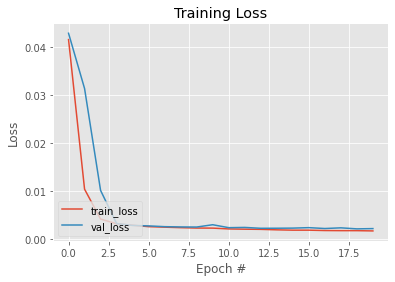

In [42]:
# construct a plot that plots and saves the training history
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig('plot_training.png')

In [44]:
# serialize the image data to disk
print("[INFO] saving image data...")
f = open('image_with_anomaly.pickle', "wb")
f.write(pickle.dumps(images))
f.close()

[INFO] saving image data...


In [45]:
# serialize the autoencoder model to disk
print("[INFO] saving autoencoder...")
autoencoder.save('autoencoder.model', save_format="h5")

[INFO] saving autoencoder...


We saved our model and images, now we can try our model to find anomalies in dataset

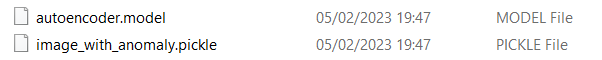

In [46]:
from tensorflow.keras.models import load_model

In [47]:
print("[INFO] loading autoencoder and image data...")
autoencoder = load_model('autoencoder.model')
images = pickle.loads(open('image_with_anomaly.pickle', "rb").read())

[INFO] loading autoencoder and image data...


In [48]:
decoded = autoencoder.predict(images)
errors = []

In [49]:
decoded.shape

(6809, 28, 28, 1)

In [50]:
# we need to calculate MSE values for all images in dataset with its reconstruction

for (image, recon) in zip(images, decoded):
    # compute the mean squared error between the ground-truth image
    # and the reconstructed image, then add it to our list of errors
    mse = np.mean((image - recon) ** 2)
    errors.append(mse)

any data point that our model reconstructed with > threshold error will be marked as an outlier

In [51]:
thresh = np.quantile(errors, 0.999)

In [52]:
thresh

0.0256554081141949

In [53]:
idxs = np.where(np.array(errors) >= thresh)[0]

In [54]:
idxs

array([ 290, 1215, 1420, 2132, 4575, 4925, 6011], dtype=int64)

In [55]:
print("[INFO] mse threshold: {}".format(thresh))
print("[INFO] {} outliers found".format(len(idxs)))

[INFO] mse threshold: 0.0256554081141949
[INFO] 7 outliers found


 We found 7 outliers in our dataset.. Real number is 67, so our model is not very good about it.
 
  Lets see what these outliers are

In [56]:
outputs = None

# loop over the indexes of images with a high mean squared error term
for i in idxs:
    # grab the original image and reconstructed image
    original = (images[i] * 255).astype("uint8")
    recon = (decoded[i] * 255).astype("uint8")

    # stack the original and reconstructed image side-by-side
    output = np.hstack([original, recon])

    # if the outputs array is empty, initialize it as the current
    # side-by-side image display
    if outputs is None:
        outputs = output

    # otherwise, vertically stack the outputs
    else:
        outputs = np.vstack([outputs, output])

In [57]:
# show the output visualization
cv2.imshow("Output", outputs)
cv2.waitKey(0)

-1

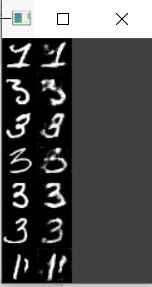

In [58]:
cv2.imwrite("Output.png", outputs)

True

FOR MORE : https://towardsdatascience.com/a-keras-based-autoencoder-for-anomaly-detection-in-sequences-75337eaed0e5

